In [1]:
import pandas as pd

hist = pd.read_csv('data/a320_pw_engine_history.csv')
ac_names = pd.read_csv('data/aircraft_names.csv')

Replace all new names with old names 

In [2]:
head_n = 2
install_n = 6
removal_n = 4
cycle_n = install_n + removal_n

eng_history = []

rec_columns = [
  "Install Date",
  "acnum",
  "Pos",
  "Aircraft FH FC",
  "Engine TSN CSN",
  "Comments",
  "Removal Date",
  "Aircraft FH FC",
  "Engine TSN CSN",
  "Reason Comments",
]

for i, row in hist.iterrows():
  engtype, esn = row[:head_n]

  c = row[head_n:].notna().sum() // (cycle_n) + 1

  rr = row[head_n: head_n + (c * cycle_n)]

  if len(rr) == 86:
    print(rr)

  records = rr.to_numpy().reshape(-1, cycle_n)

  records_pd = pd.DataFrame(records, columns=rec_columns, dtype='string')

  records_pd['Engine type'] = str(engtype)
  records_pd['ESN'] = str(esn)
  records_pd['Install Date'] = pd.to_datetime(records_pd['Install Date'], infer_datetime_format=True, errors="ignore")
  records_pd['Removal Date'] = pd.to_datetime(records_pd['Removal Date'], infer_datetime_format=True, errors="ignore")

  eng_history.append(records_pd)

eng_history = pd.concat(eng_history) \
  .dropna(subset=['Install Date']) \
  .sort_values(['acnum', 'Install Date'])

eng_history = eng_history[[
  "Install Date",
  "acnum",
  "Pos",
  "ESN",
  "Comments",
  "Removal Date",
  'Engine type'
]]

In [3]:
result_new_names = eng_history.merge(ac_names, left_on=['acnum'], right_on=['ac_reg_old'], how='left')
idx_empty = result_new_names['ac_reg_new'].isna() | (result_new_names['ac_reg_new'] == "-")
result_new_names.loc[idx_empty, 'ac_reg_new'] = result_new_names.loc[idx_empty, 'acnum']

eng_history = result_new_names.sort_values(['ac_reg_new', 'Install Date'])

eng_history.query('ESN == "P770583"')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,Engine type,ac_serial,ac_reg_old,ac_reg_new
4,2023-11-30,RA-73428,1.0,P770583,From RA-73454 / installed instead of P771745,NaT,PW1133GA-JM,NaN,NaN,RA-73428
129,2020-05-09,VQ-BGT,2.0,P770583,installed (with conversion to 27GA) after repa...,2021-03-05,PW1133GA-JM,8607.0,VQ-BGT,RA-73433
108,2018-06-26,VQ-BDU,1.0,P770583,Info from Delivery Report,2018-12-30,PW1133GA-JM,8088.0,VQ-BDU,RA-73439
114,2021-03-13,VQ-BDU,2.0,P770583,Installed instead of P771010,2021-06-04,PW1133GA-JM,8088.0,VQ-BDU,RA-73439
98,2019-07-10,VQ-BDI,1.0,P770583,installed after repair instead of P771183,2019-11-22,PW1133GA-JM,8103.0,VQ-BDI,RA-73440
170,2021-11-28,VQ-BTL,2.0,P770583,instaled after SV instead of P771584,2023-11-26,PW1133GA-JM,9193.0,VQ-BTL,RA-73454


Goal: add Engine serial number (ESN) to each record of acms 

Use pd.merge_asof (direction=backward) for this 

In [4]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202404192324.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).sort_values('reportts', ignore_index=True)

In [5]:
acms_new_names = acms_full.merge(ac_names, left_on=['acnum'], right_on=['ac_reg_old'], how='left')
idx_empty = acms_new_names['ac_reg_new'].isna() | (acms_new_names['ac_reg_new'] == "-")
acms_new_names.loc[idx_empty, 'ac_reg_new'] = acms_new_names.loc[idx_empty, 'acnum']

In [6]:
eng_history['Pos'] = eng_history['Pos'].astype(float)
 
eng_history.query('ac_reg_new == "RA-73425" and Pos == 1')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,Engine type,ac_serial,ac_reg_old,ac_reg_new
66,2017-07-20,VQ-BCF,1.0,P770327,Info from Delivery Report,2018-01-25,PW1127GA-JM,7629.0,VQ-BCF,RA-73425
68,2018-09-27,VQ-BCF,1.0,P770327,installed after repair instead of lease P770504,2018-12-11,PW1127GA-JM,7629.0,VQ-BCF,RA-73425
70,2020-04-29,VQ-BCF,1.0,P770327,installed after repair instead of P770326,2021-09-07,PW1127GA-JM,7629.0,VQ-BCF,RA-73425
71,2021-09-12,VQ-BCF,1.0,P770680,installed after repair instead of P770327,NaT,PW1127GA-JM,7629.0,VQ-BCF,RA-73425


In [7]:
merged = []

for (acnum, pos), group in acms_new_names.groupby(['ac_reg_new', 'pos']):
  history = eng_history.query('ac_reg_new == @acnum and Pos == @pos')[['Install Date', 'ESN', 'Engine type']]

  r = pd.merge_asof(
    left=group.dropna(subset=['reportts']),
    left_on='reportts',
    right_on='Install Date',
    right=history,
    direction="backward",
  )

  merged.append(r)

merged2 = pd.concat(merged)

acms_with_esn = merged2 \
  .rename(columns={'esn': '_esn', 'ESN': 'esn'}) \
  .dropna(subset=['esn'])

acms_with_esn.shape

(152434, 209)

In [8]:
acms_with_esn.to_csv("data/a320_a321_neo_full_acms_with_esn.csv")

In [9]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
import numpy as np
from gui.utils import *

alpha = 0.5
alpha_2 = 0.884

baseline_degree = 2

def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  mach_k = 1.0 + 0.2 * (data['mn_peak'] ** 2)
  theta = (data[theta_param] + 273.16) / (288.16 * mach_k)
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_config = [(0, 20_000)],
            theta_alpha = alpha_2,
            acms_data = None,
            acms_window_for_baseline = 150,
            mock_linreg = False,
            linreg_coefs = {},
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_config = alt_config
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05
        self.acms_data = acms_data
        self.mock_linreg = mock_linreg
        self.linreg_coefs = linreg_coefs
        self.acms_window_for_baseline = acms_window_for_baseline

    def _config_to_hash (self, esn: str, bleed: tuple[bool], alt: tuple[int] = (0, 0)):
        if len(bleed) == 0:
            return 0
        a = map(int, bleed)
        alt_lo, alt_hi = alt
        return f'{esn}_{"".join(map(str, a))}{str(alt_lo)}'

    def _get_bleed_filter_index(self, X, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        assert len(bleed_conf) == len(self.bleed_config)
        alt_lo, alt_hi = alt_conf
        index = (X['alt'] >= alt_lo) & (X['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == bleed_conf[i])

        return index

    def _filter_acms_data(self, acms, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        alt_lo, alt_hi = alt_conf
        index = (acms['alt'] >= alt_lo) & (acms['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (acms[field_name] == bleed_conf[i])

        return acms[index]
    
    def _fit_single_engine(self, X, esn):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'

        egt_delta = pd.DataFrame(index=X.index.copy(), columns=['base'])

        if self.acms_data is not None: 
            acms = self.acms_data \
                .query("esn == @esn") \
                .query(f"{self.x_param} > 0 and {self.y_param} > 0 and {self.theta_param} > -100")
            
            acms = theta_correct(acms, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
            # best_acms = self._find_best_acms_range(acms, x_param_k, y_param_k)
            best_acms = acms[:self.acms_window_for_baseline]

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]

                if self.acms_data is not None: 
                    best_acms_f = self._filter_acms_data(best_acms, bleed_comb, alt_split)
                    if best_acms_f.shape[0] < 2:
                        print(f"Warning: Not enough values for baseline at {bleed_comb} {alt_split}")
                        continue
                    baseline = train_engine_baseline(best_acms_f, x_param_k, y_param_k, baseline_degree)
                else:
                    if Xf.shape[0] < 2:
                        print(f"Warning: Not enough values for baseline at {bleed_comb} {alt_split}")
                        continue
                    baseline = train_engine_baseline(Xf, x_param_k, y_param_k)

                if Xf.shape[0] < 2:
                    continue

                egtm_base = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                egt_delta.loc[index, 'base'] = egtm_base

                n = self._config_to_hash(esn, bleed_comb, alt_split)
                self.baselines[n] = baseline

        return egt_delta

    def _predict_single_engine(self, X, esn):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])

        default_baseline = next(iter(self.baselines.values()))

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                n = self._config_to_hash(esn, bleed_comb, alt_split)
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]

                if n in self.baselines:
                    baseline = self.baselines[n]
                else:
                    baseline = default_baseline

                egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                if esn in self.ensemble:
                    pred_conf = self.ensemble[esn].predict(egtm.to_numpy().reshape(-1, 1))
                    pred.loc[index, 'pred'] = pred_conf
                else:
                    pred.loc[index, 'pred'] = 0

        return pred['pred']

    def fit(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()

        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
        Xk, y = Xk[X_filter], y[X_filter]

        """
        *separate* baseline for each bleed config
        later try single baseline for engine 
        but fit linreg to each bleed conf separately
        """

        self.baselines = dict()
        self.ensemble = dict()

        data = pd.concat([Xk, y], axis=1)

        grouped = data.groupby(['esn', 'Engine type'])

        for (esn, engtype), X_engine in grouped:
            egt_delta = self._fit_single_engine(X_engine, esn)

            linreg = LinearRegression()
            smooth_base_egtm = np.array(smooth(egt_delta['base'], self.smooth_factor)).reshape(-1, 1)
            
            if self.mock_linreg:
                linreg.coef_ = np.array([self.linreg_coefs[engtype][0]])
                linreg.intercept_ = self.linreg_coefs[engtype][1]
            else:
                linreg.fit(smooth_base_egtm, y=X_engine['egtm'])
            
            self.ensemble[esn] = linreg

        return self
        
    def predict(self, X, smoothed=False):
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        grouped = Xk.groupby('esn')

        for esn, _ in grouped:
            index = (Xk['esn'] == esn)
            X_engine = Xk[index]
            pred_engine = self._predict_single_engine(X_engine, esn)
            if smoothed:
                pred.loc[index, 'pred'] = smooth(pred_engine, self.smooth_factor)
            else:
                pred.loc[index, 'pred'] = pred_engine

        return pred['pred']
    
    def score(self, X, y, smoothed=False):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        Xf, yf = X[X_filter], y[X_filter]

        y_pred = self.predict(Xf.copy(), smoothed=smoothed)
        return r2_score(yf, y_pred)

In [10]:
def take_early_cycles(X, n_start = 0, n_end = 100):
  res = []
  grouped = X.groupby('esn')

  for _, group in grouped:
    res.append(group[n_start:n_end])

  return pd.concat(res)

In [11]:
x_param='n2a_peak'
y_param='egt_peak'
theta_param='tat_peak'

linreg_coefs = {
  'PW1133GA-JM': [1.0, 4.5],
  'PW1127GA-JM': [1.0, 86.4],
  'PW1127G-JM': [1.0, 86.4],
}

acms = acms_with_esn \
  .query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and mn_peak > 0") \
  .copy()

model = EGTMarginRegressor(
  bleed_config=[], 
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param,
  acms_data=acms,
  mock_linreg=True,
  linreg_coefs=linreg_coefs
)

X = acms
y = acms['egt']

model.fit(X, y)

EGTMarginRegressor(acms_data=       acnum            reportts  pos    pf  wai  nai  prv  hpv   xf  acct  \
1     VQ-BCF 2018-04-01 08:38:13    1  0.45  0.0  0.0  1.0  0.0  0.0 -20.0   
2     VQ-BCF 2018-04-01 08:38:13    1  0.45  0.0  0.0  1.0  0.0  0.0 -20.0   
3     VQ-BCF 2018-04-03 10:52:30    1  0.45  0.0  0.0  1.0  0.0  0.0 -20.0   
4     VQ-BCF 2018-04-03 10:52:30    1  0.45  0.0  0.0  1.0  0.0  0.0 -20.0   
5     VQ-BCF 2018-04-06 01:28:27    1  0.43  0.0  0.0  1.0  0.0  0.0 -20.0   
...      ...                 ...  ...   ...  ...  ...  ...  ...  ...   ...   
1...
1125  P772256  PW1127GA-JM  1150.326191   90.224931  
1126  P772256  PW1127GA-JM  1161.173857   90.692983  
1127  P772256  PW1127GA-JM  1191.897478   92.004165  
1128  P772256  PW1127GA-JM  1151.754155   90.660471  
1129  P772256  PW1127GA-JM  1152.822322   90.429895  

[147239 rows x 211 columns],
                   bleed_config=[],
                   linreg_coefs={'PW1127G-JM': [1.0, 86.4],
                                 'PW1127GA-JM': [1.0, 86.4],
                                 'PW1133GA-JM': [1.0, 4.5]},
                   mock_linreg=True, x_param='n2a_peak')

In [12]:
acms_f = acms \
  .query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and mn_peak > 0")

pred = model.predict(acms_f, smoothed=False)
pred_smooth = model.predict(acms_f, smoothed=True)


In [13]:
data = pd.concat([
  acms_f[['acnum', 'pos', 'reportts', 'esn']],
  pred.rename('egtm'), 
  pred_smooth.rename('egtm_smooth')
], axis=1)

data['experiment_version'] = 3

In [19]:
data.to_csv("export.csv", index=False)

ESN = P770583


In [15]:
eng_history.query('acnum == "VQ-BDU" and Pos == 2')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,Engine type,ac_serial,ac_reg_old,ac_reg_new
109,2018-06-26,VQ-BDU,2.0,P770704,Info from Delivery Report,2020-05-27,PW1133GA-JM,8088.0,VQ-BDU,RA-73439
111,2020-05-31,VQ-BDU,2.0,P771010,installed after repair with conversion to 33GA...,2021-03-04,PW1133GA-JM,8088.0,VQ-BDU,RA-73439
114,2021-03-13,VQ-BDU,2.0,P770583,Installed instead of P771010,2021-06-04,PW1133GA-JM,8088.0,VQ-BDU,RA-73439
115,2021-06-06,VQ-BDU,2.0,P771029,Installed after repair,NaT,PW1133GA-JM,8088.0,VQ-BDU,RA-73439


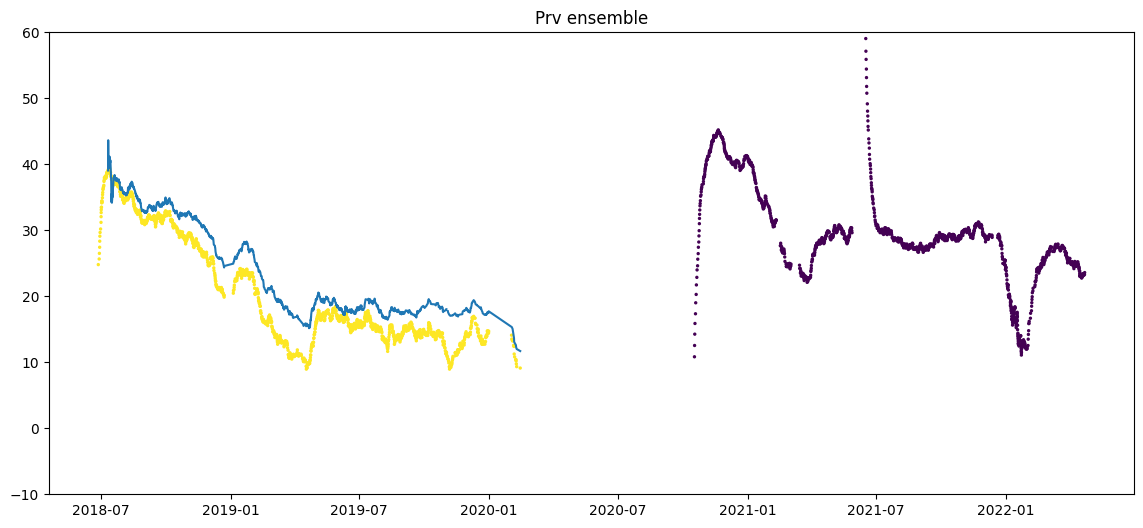

In [16]:
bgu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2')

eng = acms.query("esn == 'P770704'").query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100")

pred = model.predict(eng, smoothed=True)

plt.figure(figsize=(14, 6))
plt.ylim(-10, 60)
plt.title(f'Prv ensemble')
plt.scatter(eng['reportts'], pred, c=eng["pos"], s=2)
plt.plot(bgu['reportts'], bgu['egtm'])
plt.show()

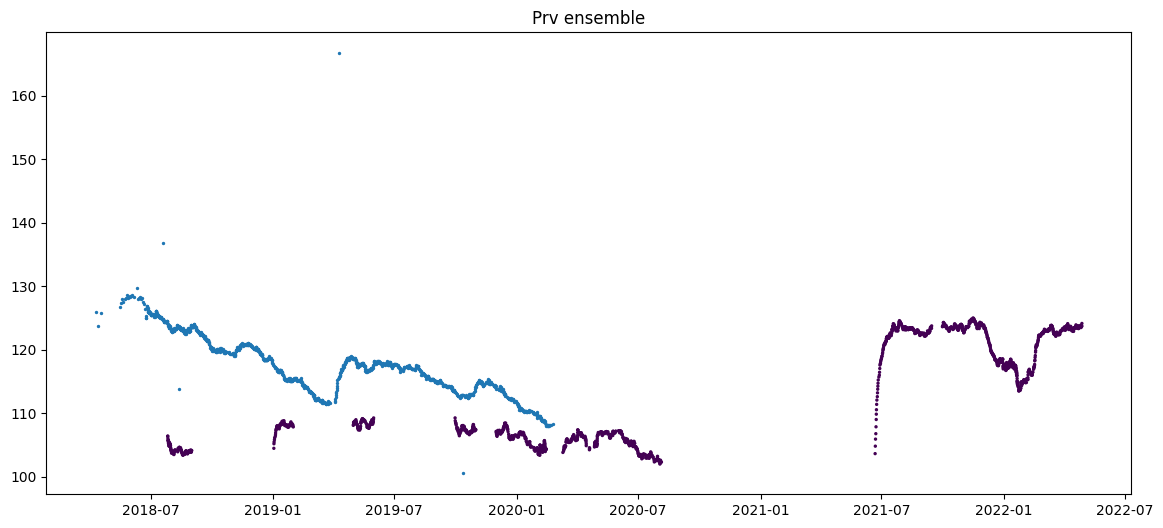

In [18]:
neo_all = pd.read_csv('./data/takeoff-merged-all-neo.csv', parse_dates=['reportts'], low_memory=False)

adem_data = pd.read_csv('./data/Data EGT N1Vib ACC ITT.csv', parse_dates=['RECORDED_DT'])
adem_data.columns = map(str.lower, adem_data.columns)
adem_bwb = adem_data.query("aircraft == 'VQ-BCR' and position == 2")

eng = acms.query("esn == 'P770338'").query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100")

pred = model.predict(eng, smoothed=True)

plt.figure(figsize=(14, 6))
plt.title(f'Prv ensemble')
plt.scatter(eng['reportts'], pred, c=eng["pos"], s=2)
plt.scatter(adem_bwb['recorded_dt'], adem_bwb['egtm'], s=2)
plt.show()